In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from random import seed
from random import randrange
from csv import reader

# New Section

In [2]:
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [3]:
#data['class'] = data['class'].replace(1, 0)
#data['class'] = data['class'].replace(2, 1)
#data['class'] = data['class'].replace(3, 1)
#print("Jumlah kemunculan nilai pada atribut psych: \n", data['class'].value_counts())


In [4]:
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

In [5]:
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset);print(dataset_copy)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [6]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0


In [7]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [8]:
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

In [9]:
def gini_index(groups, class_values):
	gini = 0.0
	for class_value in class_values:
		for group in groups:
			size = len(group)
			if size == 0:
				continue
			proportion = [row[-1] for row in group].count(class_value) / float(size)
			gini += (proportion * (1.0 - proportion))
	return gini

In [10]:
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [11]:
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

In [12]:
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)


In [13]:
def build_tree(train, max_depth, min_size):
	root = get_split(dataset)
	split(root, max_depth, min_size, 1)
	return root

In [14]:
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']


In [15]:
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)

In [47]:
filename = 'thyroid.dat'
data = pd.read_csv(filename)
X=data.iloc[:,0:21].values
#Label Set
y=data.iloc[:,21].values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

model=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
model.fit(X_train,y_train)
y_trained = model.predict(X_train)
accuracy_score_train = accuracy_score(y_trained, y_train)
print("Akurasi Score Data Train: ", accuracy_score_train)
y_tested = model.predict(X_test)
accuracy_score_tested = accuracy_score(y_test, y_tested)

print("Akurasi Score Data Test: ", accuracy_score_tested)
conf_mat = confusion_matrix(y_test, y_tested)
print("Confusion Matrix: \n", conf_mat)

from sklearn.metrics import classification_report
print (classification_report(y_test, y_tested))

Akurasi Score Data Train:  0.9369682236499393
Akurasi Score Data Test:  0.9381944444444444
Confusion Matrix: 
 [[  14    0   21]
 [   0    0   68]
 [   0    0 1337]]
              precision    recall  f1-score   support

           1       1.00      0.40      0.57        35
           2       0.00      0.00      0.00        68
           3       0.94      1.00      0.97      1337

    accuracy                           0.94      1440
   macro avg       0.65      0.47      0.51      1440
weighted avg       0.89      0.94      0.91      1440



/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

print(sum(model.tree_.children_left < 0))

prune_index(model.tree_, 0, 5)
sum(model.tree_.children_left < 0)




10


13

In [49]:
y_trained = model.predict(X_train)
accuracy_score_train = accuracy_score(y_trained, y_train)
print("Akurasi Score Data Train: ", accuracy_score_train)
y_tested = model.predict(X_test)
accuracy_score_tested = accuracy_score(y_test, y_tested)

print("Akurasi Score Data Test: ", accuracy_score_tested)
conf_mat = confusion_matrix(y_test, y_tested)
print("Confusion Matrix: \n", conf_mat)

from sklearn.metrics import classification_report
print (classification_report(y_test, y_tested))

Akurasi Score Data Train:  0.9367945823927766
Akurasi Score Data Test:  0.9375
Confusion Matrix: 
 [[  13    0   22]
 [   0    0   68]
 [   0    0 1337]]
              precision    recall  f1-score   support

           1       1.00      0.37      0.54        35
           2       0.00      0.00      0.00        68
           3       0.94      1.00      0.97      1337

    accuracy                           0.94      1440
   macro avg       0.65      0.46      0.50      1440
weighted avg       0.89      0.94      0.91      1440



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import scipy.stats as stats

z = np.abs(stats.zscore(data))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean = data[(z<3).all(axis=1)]

#find how many rows are left in the dataframe 
data_clean.shape

print(data_clean)

      0.73   0   1   0.1   0.2  ...   0.015   0.12.1   0.082    0.146   3
0     0.24   0   0     0     0  ...  0.0300  0.14300   0.133  0.10800   3
1     0.47   0   0     0     0  ...  0.0240  0.10200   0.131  0.07800   3
2     0.64   1   0     0     0  ...  0.0170  0.07700   0.090  0.08500   3
3     0.23   0   0     0     0  ...  0.0260  0.13900   0.090  0.15300   3
4     0.69   1   0     0     0  ...  0.0160  0.08600   0.070  0.12300   3
...    ...  ..  ..   ...   ...  ...     ...      ...     ...      ...  ..
7193  0.35   0   0     0     0  ...  0.0200  0.09000   0.080  0.11300   3
7194  0.36   0   0     0     0  ...  0.0201  0.11329   0.096  0.11776   3
7195  0.27   0   0     0     0  ...  0.0201  0.09000   0.082  0.11000   3
7196  0.26   1   0     0     0  ...  0.0201  0.08000   0.075  0.10700   3
7197  0.95   0   0     0     0  ...  0.0201  0.09800   0.091  0.10800   3

[4781 rows x 22 columns]


In [ ]:
from sklearn.model_selection import cross_val_score
for depth in range(1,10):
 tree_classifier = tree.DecisionTreeClassifier(
  max_depth=depth, random_state=0)
 if tree_classifier.fit(X_train,y_train).tree_.max_depth < depth:
  break
 score = np.mean(cross_val_score(tree_classifier, X_train,y_train, scoring='accuracy', cv=3, n_jobs=1))
 print('Depth: %i Accuracy: %.3f' % (depth,score))

Depth: 1 Accuracy: 0.954
Depth: 2 Accuracy: 0.976
Depth: 3 Accuracy: 0.991
Depth: 4 Accuracy: 0.995
Depth: 5 Accuracy: 0.993
Depth: 6 Accuracy: 0.993
Depth: 7 Accuracy: 0.993
Depth: 8 Accuracy: 0.993
Depth: 9 Accuracy: 0.993


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


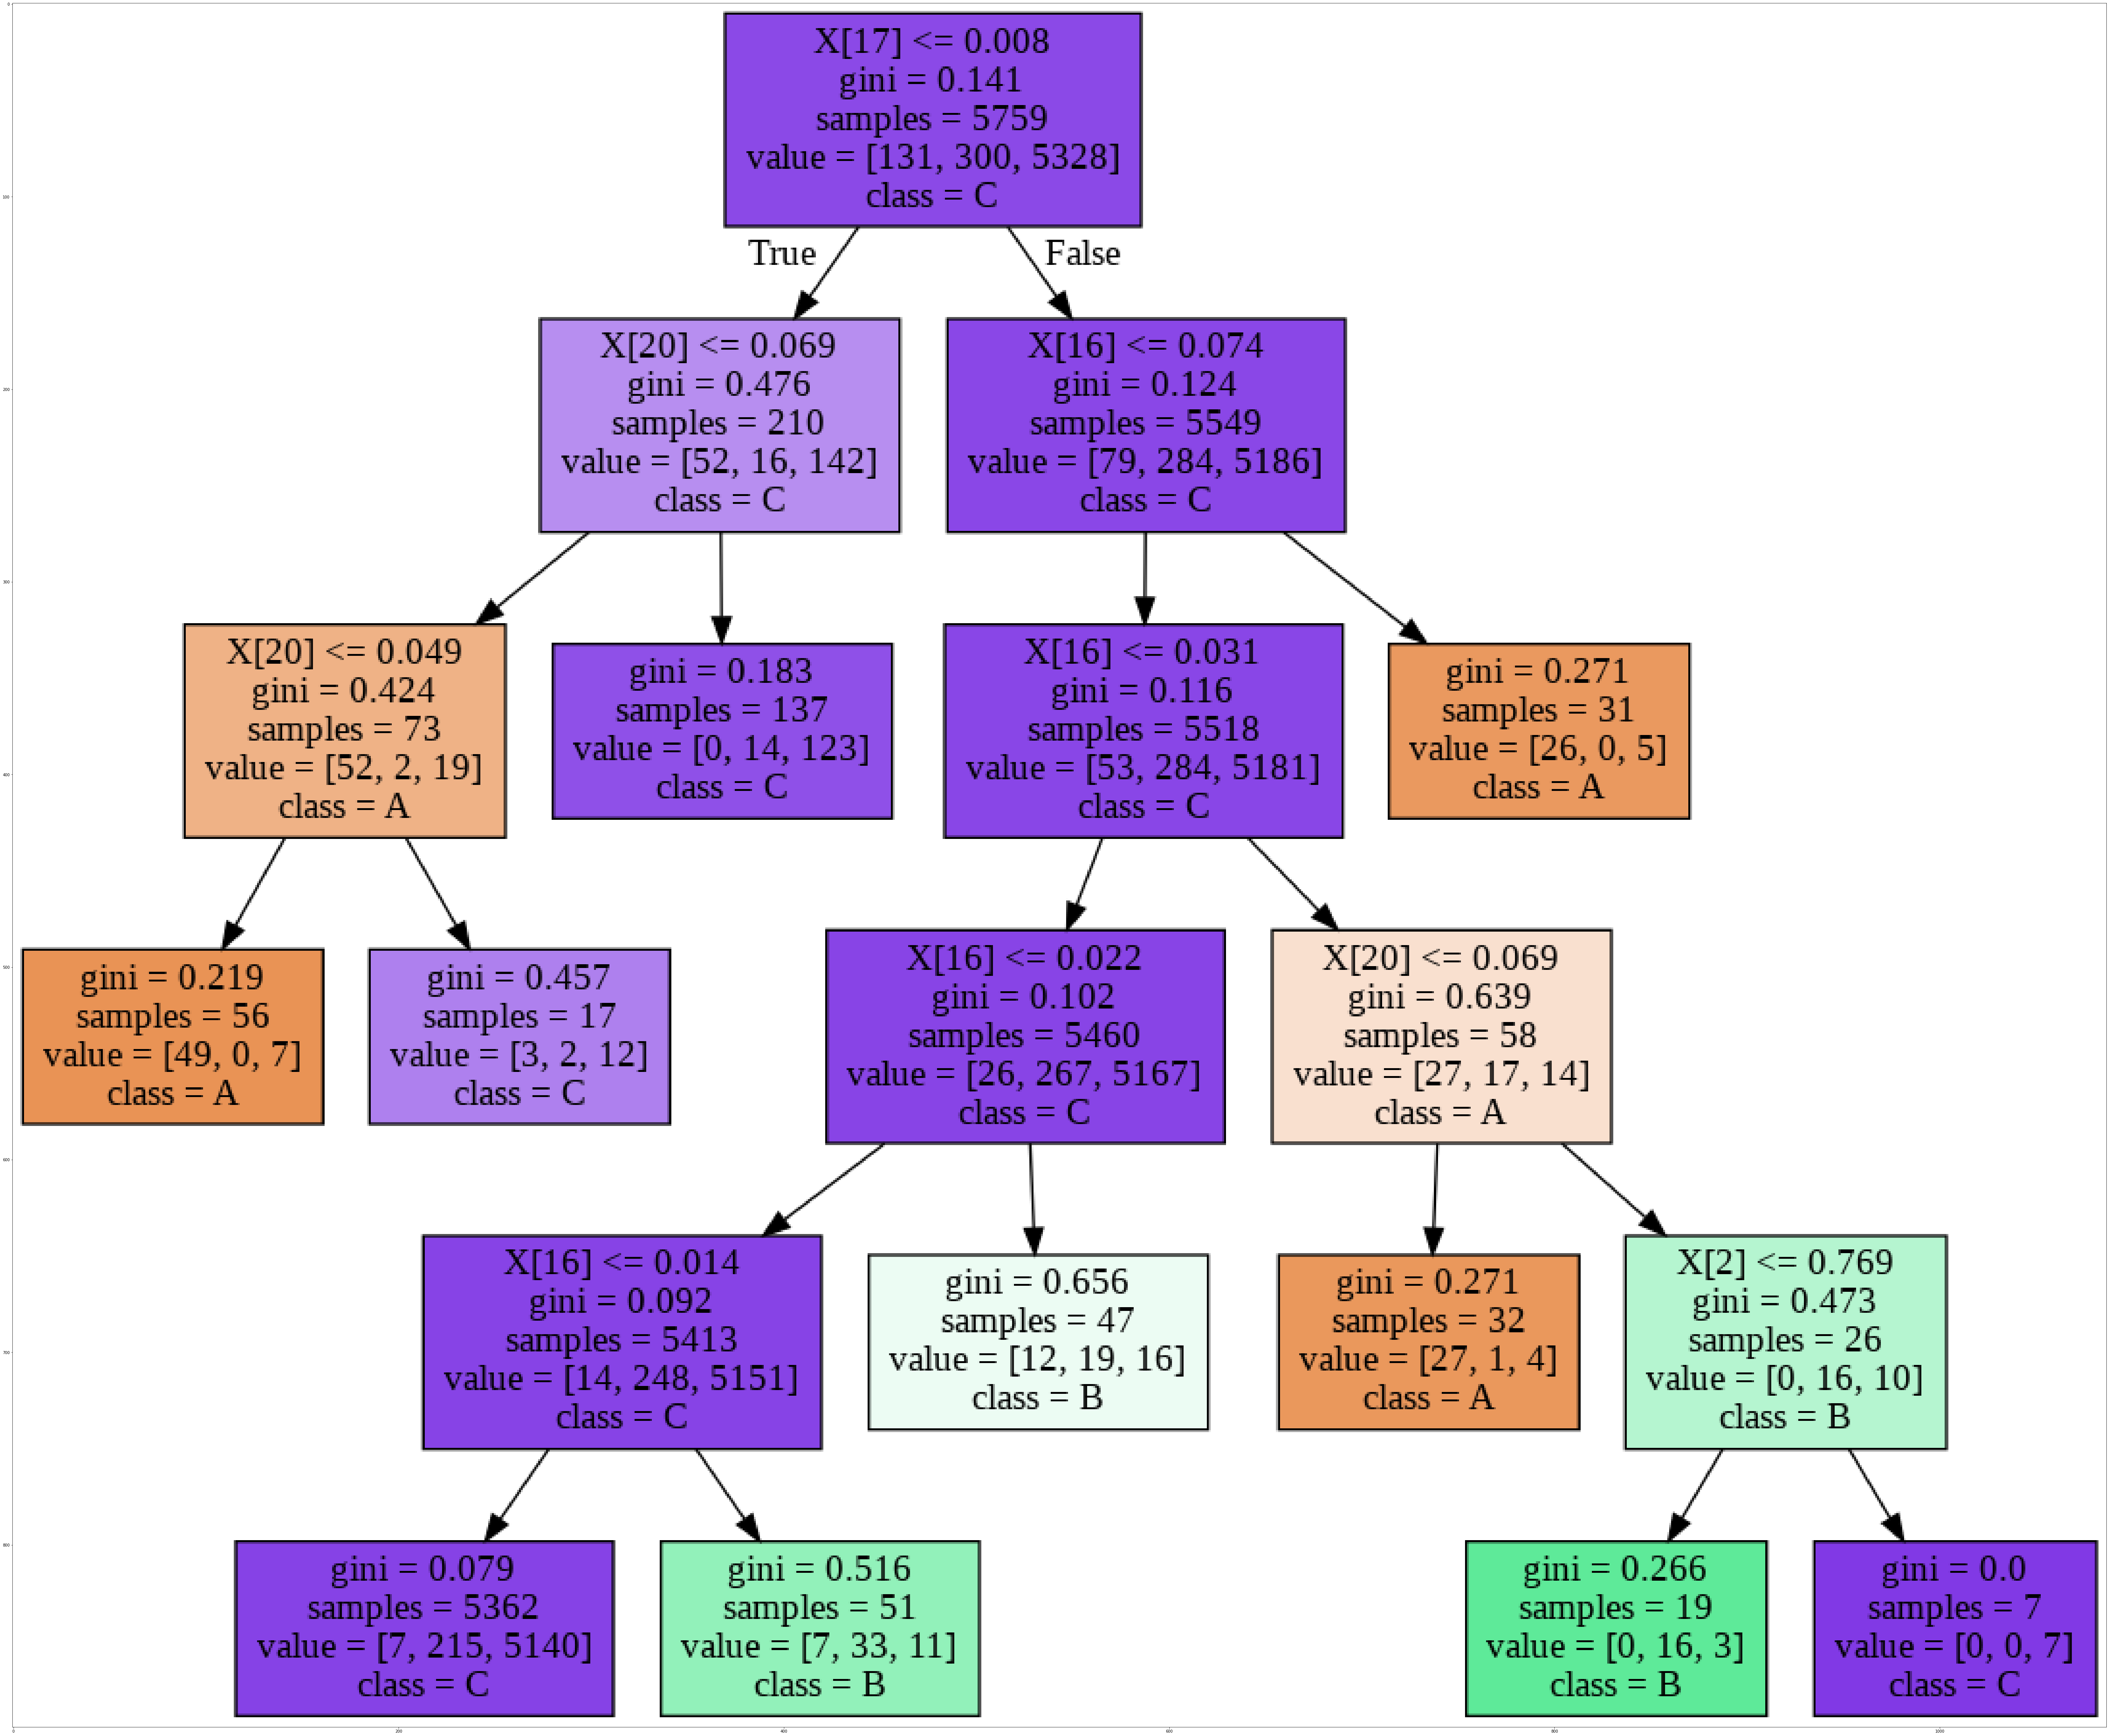

In [43]:
from IPython.display import Image  
from sklearn import tree
import matplotlib.image as mpimg
import pydotplus
import io
import matplotlib.pyplot as plt

import sys

rt = model.fit(X_train, y_train)

str1 = "/usr/local/Cellar/graphviz/2.40.1_1/bin/"
sys.path.append(str1)

dot_data = io.StringIO()
tree.export_graphviz(rt, out_file=dot_data, filled=True, class_names = 'ABC')

# Draw graph
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png('dt.png')

plt.figure(figsize=(100, 100))
img = mpimg.imread('dt.png')
imgplot = plt.imshow(img)

plt.show()

In [ ]:
# Test CART on Bank Note dataset
seed(1)
# load and prepare data
filename = 'thyroid.dat'
dataset = load_csv(filename)
# convert string attributes to integers

# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

[['0.73', ' 0', ' 1', ' 0', ' 0', ' 0', ' 0', ' 0', ' 1', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.0006', ' 0.015', ' 0.12', ' 0.082', ' 0.146', ' 3'], ['0.24', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.00025', ' 0.03', ' 0.143', ' 0.133', ' 0.108', ' 3'], ['0.47', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.0019', ' 0.024', ' 0.102', ' 0.131', ' 0.078', ' 3'], ['0.64', ' 1', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.0009', ' 0.017', ' 0.077', ' 0.09', ' 0.085', ' 3'], ['0.23', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.00025', ' 0.026', ' 0.139', ' 0.09', ' 0.153', ' 3'], ['0.69', ' 1', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0.00025', ' 0.016', ' 0.086', ' 0.07', ' 0.123', ' 3'], ['0.85', ' 1', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 0', ' 

KeyboardInterrupt: ignored